# Solving a 2nd-order ODE BVP with a neural network

## Setup

In [1]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [2]:
from math import exp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Introduction

This notebook will demonstrate how to use the code in the `nnode2bvp.py` module. The module allows the user to solve 2nd-order ordinary differential equation (ODE) boundary value problems (BVPs) using a single-hidden layer neural network.

This work is based on the paper ["Artificial Neural Networks for Solving Ordinary and Partial Differential Equations", by Lagaris et al, *IEEE Transactions on Neural Networks, Volume 9, No. 5*, September 1998](http://ieeexplore.ieee.org/document/712178/). Note that the notation used in this notebook and the associated Python code differs slightly from that used in the Lagaris paper.

## The algorithm

Any 2nd-order ODE can be written in the form:

\begin{equation}
G\left(x,y,\frac {dy}{dx},\frac {d^2y}{dx^2}\right) = 0
\end{equation}

The problem is to find a solution $y(x)$ to the ODE using a neural network, subject to the boundary conditions:

\begin{equation}
y(0)=A
\end{equation}

\begin{equation}
y(1)=B
\end{equation}

The network is trained using a set of *training points* $x_i$ ($1 \le i \le n$), defined on the domain of interest. The training points need not be evenly-spaced. Note that only the independent variable values $x_i$ of the training points are needed - the estimated value of the solution at those training points is obtained using a trial solution. Such an ODE can always be scaled and mapped onto the domain $[0,1]$, and this code assumes such mapping has already been performed. For a 2nd-order ODE BVP, the trial solution has the form:

\begin{equation}
y_t(x_i) = A (1 - x_i) + B x_i + x_i (1 - x_i) N(x_i)
\end{equation}

or:

\begin{equation}
y_{ti} = A (1 - x_i) + B x_i + x_i (1 - x_i) N_i
\end{equation}

where $y_{ti}=y_t(x_i)$ is the value of the trial solution at the current training point $x_i$, $A$ is the boundary condition ($y(0)$), $B$ is the boundary condition ($y(1)$), and $N_i=N(x_i)$ is the single-valued floating-point output from an unspecified neural network. Note that this trial solution satisfies the boundary conditions by construction - at $x=0$, the second and third terms vanish, leaving $y_t(0)=A$, while at $x=1$, the first and third terms vanish.

Training is done in a set of *epochs*. A training epoch consists of presenting the neural network with each of the $n$ training points $x_i$, one at a time. For each input value $x_i$, the network output $N_i$ is computed, and used to compute the value of the trial solution $y_{ti}$. Once all $n$ points have been presented, the epoch is complete, and the error function $E$ is computed. The ODE definition (1) should vanish at convergence, and so an appropriate form for the error function is:

\begin{equation}
E = \sum_{j=1}^{n}G_i^2
\end{equation}

where $G_i$ is:

\begin{equation}
G_i = G\left(x_i,y_{ti},\frac {\partial y_{ti}}{\partial x_i},\frac {\partial^2 y_{ti}}{\partial x_i^2}\right)
\end{equation}

where $\frac {\partial y_{ti}}{\partial x_i}$ and $\frac {\partial^2 y_{ti}}{\partial x_u^2}$ are the first and second derivatives of the trial function with respect to $x$, evaluated at $x_i$. These derivatives are the current approximations of the analytical derivatives $\frac {dy}{dx}$ and $\frac {d^2y}{dx^2}$. Once this error function is computed, the weights and biases in the neural network are adjusted to reduce the error. Eventually, a minimum of $E$ is attained, and the resulting final form of $y_t(x)$ is used as the solution to the original ODE.

## Computing the network output $N_i$

The neural network used in this work has a simple structure. A single input node is used to provide the training data. The input node is fully-connected to a set of $H$ hidden nodes. Each hidden node is connected to a single output node.

During each step of a training epoch, the input to the network, and thus the output of the single input node, is just the training point $x_i$. This single output is then sent to each of the $H$ hidden nodes. At each hidden node $k$, the input value $x_i$ is scaled by the equation:

\begin{equation}
z_{ik} = w_k x_i + u_k
\end{equation}

where $z_{ij}$ is the transformed input at hidden node $j$, $w_j$ is the weight at node $j$, and $u_j$ is the bias at node $j$. This scaled value is then used as the input to a sigmoidal transfer function:

\begin{equation}
\sigma_{ik} = \sigma(z_{ik})
\end{equation}

where:

\begin{equation}
\sigma(z) = \frac {1}{1+e^{-z}}
\end{equation}

A plot of this transfer function and its first several derivatives is provided below.

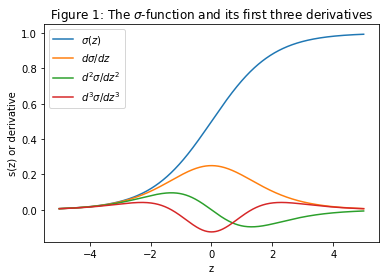

In [3]:
def sigma(z):
    return 1 / (1 + exp(-z))

def dsigma_dz(z):
    return exp(-z) / (1 + exp(-z))**2

def d2sigma_dz2(z):
    return (
        2 * exp(-2 * z) / (1 + exp(-z))**3 - exp(-z) / (1 + exp(-z))**2
    )

def d3sigma_dz3(z):
    return (
        6 * exp(-3 * z) / (1 + exp(-z))**4
        - 6 * exp(-2 * z) / (1 + exp(-z))**3
        + exp(-z) / (1 + exp(-z))**2
    )

z = np.linspace(-5, 5, 1001)
n = len(z)
s = np.zeros(n)
ds_dz = np.zeros(n)
d2s_dz2 = np.zeros(n)
d3s_dz3 = np.zeros(n)
for i in range(n):
    s[i] = sigma(z[i])
    ds_dz[i] = dsigma_dz(z[i])
    d2s_dz2[i] = d2sigma_dz2(z[i])
    d3s_dz3[i] = d3sigma_dz3(z[i])
plt.plot(z,s,label = "$\sigma(z)$")
plt.plot(z,ds_dz,label = "$d\sigma/dz$")
plt.plot(z,d2s_dz2, label = "$d^2\sigma/dz^2$")
plt.plot(z,d3s_dz3, label = "$d^3\sigma/dz^3$");
plt.xlabel("z")
plt.ylabel("s(z) or derivative")
plt.title("Figure 1: The $\sigma$-function and its first three derivatives")
plt.legend();

Once the $\sigma_{ik}$ are computed, they are all passed to the single output node, where they are summed by a linear transfer function to create the network output for the current value of $x_i$:

\begin{equation}
N_i = \sum_{k=1}^{H}v_k\sigma_{ik}
\end{equation}

where $v_k$ is the weight applied to the signal from hidden node $k$ at the output node. Once $N_i$ has been computed, the trial function $y_{ti}$ and its derivatives $\frac {\partial y_{ti}}{\partial x_i}$ and $\frac {\partial^2 y_{ti}}{\partial x_i^2}$ are computed, and then the value of the ODE $G_i$ is computed, and finally the error function $E$.

## Updating the network parameters

The network parameters are the weights and biases of the hidden and output nodes. For a set of $H$ hidden nodes, we have a total of $N_p = 3H$ parameters in total: a weight and bias for each hidden node, and an output weight for each hidden node.

Since the objective function to minimize is the error $E$, the value of each network parameter $p$ (where $p$ represents $v_k$, $u_k$, or $w_k$) is updated using a scaled, simpified Newton's method:

\begin{equation}
p_{new}=p - \eta \frac {\partial E}{\partial {p}}
\end{equation}

where $\eta$ is the *learning rate* (usually $\eta < 1$). This simplified method (ignoring the usual 2nd derivative in the denominator of the correction term) is appropriate when the problem is scaled to the domain $[0,1]$.The learning rate is used to reduce the chance of solution instability due to large values of the correction term. The derivatives of $E$ are computed using the known form of the network and internal parameters.

This process of parameter updates is repeated until convergence is achieved (an error minimum is reached), or until the specified maximum number of training epochs have been applied. Note that the same set of training points is presented during each epoch.

## Computing the derivatives of $E$

The first derivative of $E$ with respect to any network parameter $p$ is given by:

\begin{equation}
\frac {\partial E}{\partial p} =
\frac {\partial}{\partial p} \sum_{i=1}^{n}G_i^2 =
2 \sum_{i=1}^n G_i \frac {\partial G_i}{\partial p}
\end{equation}

## Computing the derivatives of $G_i$

The partial derivative of $G_i$ with respect to any network parameter $p$ is computed using the chain rule:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial}{\partial p} G\left(x_i,y_{ti},\frac {\partial y_{ti}}{\partial x_i},\frac {\partial^2y_{ti}}{\partial x_i^2}\right) =
\frac {\partial G_i}{\partial x_i} \frac {\partial x_i}{\partial p} +
\frac {\partial G_i}{\partial y_{ti}} \frac {\partial y_{ti}}{\partial x_i} +
\frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}} \frac {\partial^2 y_{ti}}{\partial p \partial x_i} +
\frac {\partial G_i}{\partial \frac {\partial^2 y_{ti}}{\partial x_i^2}} \frac {\partial^3 y_{ti}}{\partial p \partial x_i^2}
\end{equation}

Since the training points $x_i$ are independent of the network parameters $\vec p$, this equation simplifies to:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial G_i}{\partial y_{ti}} \frac {\partial y_{ti}}{\partial x_i} +
\frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}} \frac {\partial^2 y_{ti}}{\partial p \partial x_i} +
\frac {\partial G_i}{\partial \frac {\partial^2 y_{ti}}{\partial x_i^2}} \frac {\partial^3 y_{ti}}{\partial p \partial x_i^2}
\end{equation}

The analytical forms of $\frac {\partial G_i}{\partial y_{ti}}$, $\frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}}$, and $\frac {\partial G_i}{\partial \frac {\partial^2 y_{ti}}{\partial x_i^2}}$ are determined from the analytical form of the original ODE.

## Computing the derivatives of $y_{ti}$

The generic form of the first derivative of $y_{ti}$ is:

\begin{equation}
\frac {\partial y_{ti}}{\partial x_i} = -A + B + x_i(1-x_i) \frac {\partial N_i}{\partial x_i} +(1-2x_i) N_i
\end{equation}

The cross-partial of $y_{ti}$ is then:

\begin{equation}
\frac {\partial^2 y_{ti}}{\partial p \partial x_i} =
x_i(1-x_i) \frac {\partial^2 N_i}{\partial p \partial x_i} +(1-2x_i) \frac {\partial N_i}{\partial p}
\end{equation}

The generic form of the second derivative of $y_{ti}$ is:

\begin{equation}
\frac {\partial^2 y_{ti}}{\partial x_i^2} =
x_i(1-x_i) \frac {\partial^2 N_i}{\partial x_i^2} +
2(1-2x_i) \frac {\partial N_i}{\partial x_i} -
2 N_i
\end{equation}

The cross-partial is then:

\begin{equation}
\frac {\partial^3 y_{ti}}{\partial p \partial x_i^2} =
x_i(1-x_i) \frac {\partial^3 N_i}{\partial p \partial x_i^2} +
2(1-2x_i) \frac {\partial^2 N_i}{\partial p \partial x_i} -
2 \frac {\partial N_i}{\partial p}
\end{equation}

## Computing the derivatives of $N_i$

The generic form of the first derivative of $N_i$ with respect to $x_i$ is:

\begin{equation}
\frac {\partial N_i}{\partial x_i} =
\frac {\partial}{\partial x_i} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial z_{ik}} \frac {\partial z_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k
\end{equation}

where the transfer function derivatives are defined by:

\begin{equation}
\sigma^{(n)} = \frac {\partial^n \sigma}{\partial z^n}
\end{equation}

For the parameter derivatives:

\begin{equation}
\frac {\partial N_i}{\partial p} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H \left ( v_k \frac {\partial \sigma_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right )
\end{equation}

For the cross-partials:

\begin{equation}
\frac {\partial^2 N_i}{\partial p \partial x_i} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_k}{\partial p} +
v_k \frac {\partial \sigma_{ik}^{(1)}}{\partial p}  w_k +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_k \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_k}{\partial p} +
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}}{\partial p}  w_k +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_k \right )
\end{equation}

The generic form of the second derivative of $N_i$ with respect to $x_i$ is:

\begin{equation}
\frac {\partial^2 N_i}{\partial x_i^2} =
\frac {\partial}{\partial x_i} \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k =
\sum_{k=1}^H v_k \sigma_{ik}^{(2)} w_k^2
\end{equation}

For the cross-partials:

\begin{equation}
\frac {\partial^3 N_i}{\partial p \partial x_i^2} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik}^{(2)} w_k^2 =
\sum_{k=1}^H \left(
v_k \sigma_{ik}^{(2)} 2 w_k \frac {\partial w_k}{\partial p} +
v_k \sigma_{ik}^{(3)} \frac {\partial z_{ik}}{\partial p} w_k^2 +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(2)} w_k^2
\right)
\end{equation}

## Computing the derivatives of $z_{ik}$

The derivatives of $z_{ik}$ with respect to the network parameter $p$ are parameter-specific:

\begin{equation}
\frac {\partial z_{il}}{\partial v_k} = 0
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial u_k} = \delta_{kl}
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial w_k} = x_i \delta_{kl}
\end{equation}

## Computing the derivatives of the parameters $\vec p$

At this lowest level, the parameter derivatives are simple in form:

\begin{equation}
\frac {\partial v_l}{\partial v_k} = \delta_{kl}, \frac {\partial v_l}{\partial u_k} = 0, \frac {\partial v_l}{\partial w_k} = 0
\end{equation}

\begin{equation}
\frac {\partial u_l}{\partial v_k} = 0, \frac {\partial u_l}{\partial u_k} = \delta_{kl}, \frac {\partial u_l}{\partial w_k} = 0
\end{equation}

\begin{equation}
\frac {\partial w_l}{\partial v_k} = 0, \frac {\partial w_l}{\partial u_k} = 0, \frac {\partial w_l}{\partial w_k} = \delta_{kl}
\end{equation}

Or, more succinctly:

\begin{equation}
\frac {\partial p_l}{\partial p_k} = \delta_{kl}
\end{equation}

# Walking through an example problem

We will now walk through a complete problem which will illustrate how to use the nnode2bvp code to solve a 2nd-order ODE BVP.

## Define the ODE to solve, and the boundary conditions

Consider the simple 2nd-order ODE, defined on the domain $[0, 1]$:

\begin{equation}
G\left(x,y,\frac {dy}{dx},\frac {d^2y}{dx^2}\right) = \frac {d^2y}{dx^2} - \frac {dy}{dx} + 2x - 1 = 0
\end{equation}

The analytical solution is:

\begin{equation}
y(x) = x^2 + x + 1
\end{equation}

The analytical solution and its derivatives are shown in the figure below.

In [4]:
def ya(x):
    return x**2 + x + 1

def dya_dx(x):
    return 2*x + 1

def d2ya_dx2(x):
    return 2

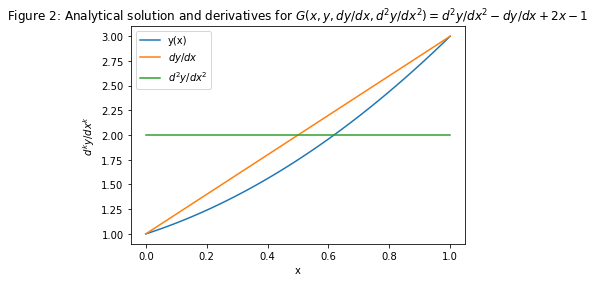

In [5]:
xmin = 0
xmax = 1
n = 100
x = np.linspace(xmin, xmax, n)
y = np.zeros(n)
dy_dx = np.zeros(n)
d2y_dx2 = np.zeros(n)
for i in range(n):
    y[i] = ya(x[i])
    dy_dx[i] = dya_dx(x[i])
    d2y_dx2[i] = d2ya_dx2(x[i])
plt.xlabel('x')
plt.ylabel('$d^ky/dx^k$')
plt.plot(x, y, label = 'y(x)')
plt.plot(x, dy_dx, label = "$dy/dx$")
plt.plot(x, d2y_dx2, label = "$d^2y/dx^2$")
plt.legend()
plt.title("Figure 2: Analytical solution and derivatives for $G(x,y,dy/dx,d^2y/dx^2)=d^2y/dx^2-dy/dx+2x-1$");

Define the differential equation itself, and its derivatives.

In [6]:
# Define the original differential equation:
def G(x, y, dy_dx, d2y_dx2):
    return d2y_dx2 - dy_dx + 2*x - 1

# Define the y-partial derivative of the differential equation.
def dG_dy(x, y, dy_dx, d2y_dx2):
    return 0

# Define the dy/dx-partial derivative of the differential equation.
def dG_dydx(x, y, dy_dx, d2y_dx2):
    return -1

# Define the d2y/dx2-partial derivative of the differential equation.
def dG_d2ydx2(x, y, dy_dx, d2y_dx2):
    return 1

The boundary conditions are:

In [7]:
A = 1
B = 3

## Create the training data

For the purposes of this example, an evenly-spaced set of training points will be used to train the neural network.

In [8]:
nt = 10
xt = np.linspace(xmin, xmax, num = nt)

Note that repeated runs of the same ODE will usually result in slightly different solutions, due to the random number generator. To ensure repeatable results, seed the random number generator with a fixed value before each run.

## Train the model to solve the ODE

We can now train the network. The call below shows the minimum arguments required to call the `nnode2bvp()` function. All tunable parameters (learning rate `eta`, hidden layer size `H`, number of training epochs `max_epochs`) are given default values (`0.01`, `10`, `1000`, respectively). The training function returns the estimated values of $y$, $\frac {dy}{dx}$, and $\frac {d^2y}{dx^2}$ at the training points. When the `verbose` option is set to `True`, the function prints out the epoch number and current value of the mean-squared error of $G_i$.

In [9]:
from nnode2bvp import nnode2bvp
A = ya(xmin)
B = ya(xmax)
np.random.seed(0)
(yt, dyt_dx, d2yt_dx2) = nnode2bvp(G, A, B, dG_dy, dG_dydx, dG_d2ydx2, xt, verbose = True)

0 16.627267750278417
1 29.448850592503728
2 30.665477467962315
3 4.235679483835625
4 3.460095242964523
5 2.7958881597141305
6 2.237722880894418
7 1.781101905334355
8 1.4189789145038825
9 1.1408395244615823
10 0.9333576762320867
11 0.7818780606248554
12 0.6721575461975605
13 0.5918694653754915
14 0.5314453027475474
15 0.48413061814714503
16 0.4455010928793875
17 0.4128054528193057
18 0.3843822248984837
19 0.3592351347341284
20 0.3367570277754644
21 0.31656220546416747
22 0.2983888159417972
23 0.282043538528078
24 0.26737081470001645
25 0.2542360092535136
26 0.24251638934388736
27 0.23209647783392753
28 0.2228658586652475
29 0.21471835698727226
30 0.20755197811605838
31 0.20126923987885503
32 0.19577767137736332
33 0.19099033237312782
34 0.18682626014772577
35 0.18321078873031865
36 0.18007571464776698
37 0.17735930578325268
38 0.17500616605737193
39 0.1729669788557789
40 0.17119815713530234
41 0.16966142900534462
42 0.16832338552286796
43 0.16715501362878696
44 0.1661312325677913
45 0.1

376 0.10966820485849128
377 0.10956299242973709
378 0.10945798845643416
379 0.10935319231529839
380 0.10924860338554102
381 0.10914422104886008
382 0.10904004468942168
383 0.10893607369385229
384 0.10883230745122534
385 0.10872874535304683
386 0.10862538679324577
387 0.1085222311681615
388 0.10841927787653062
389 0.108316526319476
390 0.1082139759004935
391 0.1081116260254439
392 0.10800947610253583
393 0.10790752554231829
394 0.10780577375766659
395 0.10770422016377262
396 0.10760286417813164
397 0.10750170522053264
398 0.10740074271304552
399 0.10729997608001021
400 0.10719940474802624
401 0.10709902814594137
402 0.1069988457048395
403 0.1068988568580314
404 0.1067990610410405
405 0.10669945769159767
406 0.10660004624962431
407 0.10650082615722488
408 0.10640179685867719
409 0.10630295780041907
410 0.1062043084310387
411 0.10610584820126512
412 0.10600757656395747
413 0.1059094929740932
414 0.10581159688876046
415 0.1057138877671444
416 0.10561636507052025
417 0.10551902826224156
418

773 0.0796580548103777
774 0.07960379970740415
775 0.07954962135940356
776 0.07949551960270099
777 0.07944149427408938
778 0.07938754521082442
779 0.07933367225062547
780 0.07927987523167332
781 0.0792261539926097
782 0.0791725083725331
783 0.07911893821099893
784 0.07906544334801861
785 0.07901202362405477
786 0.07895867888002416
787 0.07890540895729073
788 0.07885221369767027
789 0.07879909294342365
790 0.07874604653725618
791 0.07869307432231856
792 0.0786401761422035
793 0.07858735184094232
794 0.07853460126300962
795 0.0784819242533132
796 0.0784293206571985
797 0.07837679032044617
798 0.07832433308926916
799 0.07827194881031083
800 0.07821963733064607
801 0.07816739849777778
802 0.0781152321596342
803 0.07806313816457137
804 0.0780111163613676
805 0.07795916659922317
806 0.07790728872776063
807 0.07785548259702156
808 0.07780374805746552
809 0.07775208495996758
810 0.07770049315581974
811 0.0776489724967261
812 0.07759752283480353
813 0.07754614402257935
814 0.07749483591299139
8

Plot the results of this training run.

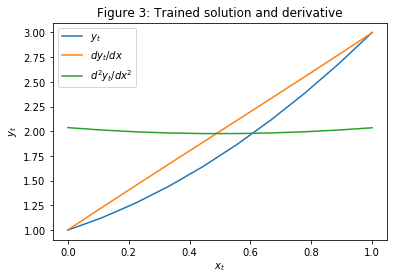

In [10]:
plt.plot(xt, yt, label = '$y_t$')
plt.plot(xt, dyt_dx, label = '$dy_t/dx$')
plt.plot(xt, d2yt_dx2, label = '$d^2y_t/dx^2$')
plt.xlabel('$x_t$')
plt.ylabel('$y_t$')
plt.legend()
plt.title("Figure 3: Trained solution and derivative");

Plot the error in the estimated solution and derivatives.

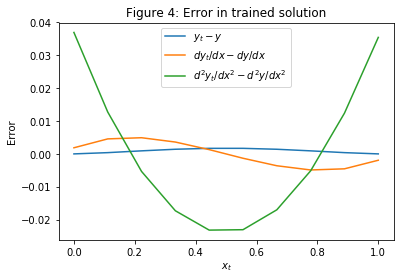

In [11]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
d2y_dx2 = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
    d2y_dx2[i] = d2ya_dx2(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.plot(xt, d2yt_dx2 - d2y_dx2, label = '$d^2y_t/dx^2-d^2y/dx^2$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 4: Error in trained solution");

Now try repeating the analysis with a larger number of hidden nodes, and plot the error.

In [12]:
np.random.seed(0)
(yt, dyt_dx, d2yt_dx2) = nnode2bvp(G, A, B, dG_dy, dG_dydx, dG_d2ydx2, xt, nhid = 20)

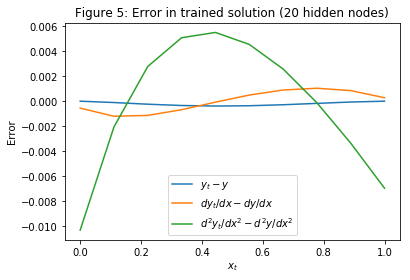

In [13]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
d2y_dx2 = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
    d2y_dx2[i] = d2ya_dx2(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.plot(xt, d2yt_dx2 - d2y_dx2, label = '$d^2y_t/dx^2-d^2y/dx^2$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 5: Error in trained solution (20 hidden nodes)");

Now try repeating the analysis with a slightly larger learning rate, and plot the error.

In [14]:
np.random.seed(0)
(yt, dyt_dx, d2yt_dx2) = nnode2bvp(G, A, B, dG_dy, dG_dydx, dG_d2ydx2, xt, nhid = 20, eta = 0.02)

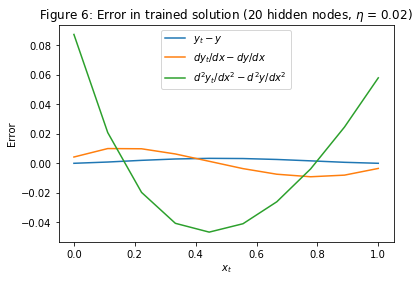

In [15]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
d2y_dx2 = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
    d2y_dx2[i] = d2ya_dx2(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.plot(xt, d2yt_dx2 - d2y_dx2, label = '$d^2y_t/dx^2-d^2y/dx^2$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 6: Error in trained solution (20 hidden nodes, $\eta$ = 0.02)");

Now try repeating the analysis with a larger number of training epochs, and plot the error.

In [16]:
np.random.seed(0)
(yt, dyt_dx, d2yt_dx2) = nnode2bvp(G, A, B, dG_dy, dG_dydx, dG_d2ydx2, xt, nhid = 20, eta = 0.02, maxepochs = 2000)

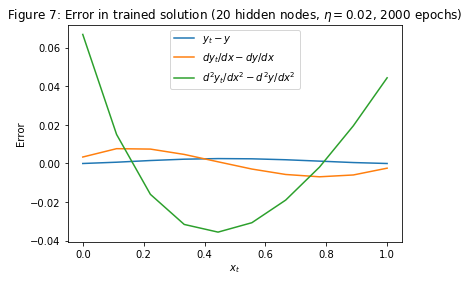

In [17]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.plot(xt, d2yt_dx2 - d2y_dx2, label = '$d^2y_t/dx^2-d^2y/dx^2$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 7: Error in trained solution (20 hidden nodes, $\eta=0.02$, 2000 epochs)");

## Using a ODE definition module

Rather than entering ODE definitions in this notebook, the required definitions can be entered in a separate Python module, and imported. For example, the previous code is also encapsulated in the module lagaris03ivp.py, and can be imported:

In [18]:
import ode01bvp

We can now run the net using the information in this module.

In [19]:
np.random.seed(0)
(yt, dyt_dx, d2yt_dx2) = nnode2bvp(ode01bvp.Gf, ode01bvp.bc0, ode01bvp.bc1, ode01bvp.dG_dyf, ode01bvp.dG_dydxf, ode01bvp.dG_d2ydx2f, xt, nhid = 20, eta = 0.02, maxepochs = 2000)

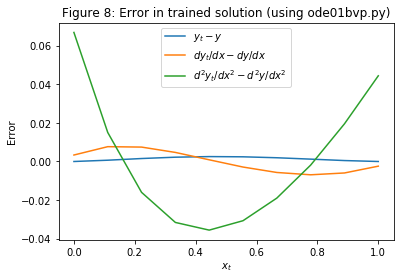

In [20]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ode01bvp.yaf(xt[i])
    dy_dx[i] = ode01bvp.dya_dxf(xt[i])
    d2y_dx2[i] = ode01bvp.d2ya_dx2f(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.plot(xt, d2yt_dx2 - d2y_dx2, label = '$d^2y_t/dx^2-d^2y/dx^2$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 8: Error in trained solution (using ode01bvp.py)");